### Переходим к практике

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import path
import itertools

from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer

from functools import lru_cache, reduce

from tqdm.notebook import tqdm_notebook, tqdm

#предобработка текстов
import re
from nltk.corpus import stopwords
from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2  # pip install pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
                            classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt


In [2]:
%matplotlib inline

In [3]:
tqdm_notebook.pandas()

In [4]:
# Save/Load objects to pickle
def pickle_save(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)
        
        
def pickle_load(file_name):
    with open(file_name, 'rb') as f:
        data_new = pickle.load(f)
    return data_new

Files

In [5]:
NEWS_FILE = "articles.csv"
USERS_FILE = "users_articles.csv"
TARGET_FILE = "users_churn.csv"

Наши новости

In [6]:
news = pd.read_csv(NEWS_FILE)
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [7]:
users = pd.read_csv(USERS_FILE)
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [8]:
target = pd.read_csv(TARGET_FILE)
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [9]:
# Анализатор морфологии слова - приводит к единой форме слова-производные(нпример: бежать, бегут, бегали, ... -> бегать)
# morph = pymorphy2.MorphAnalyzer()

### Собираем stopwords

In [10]:
MANUAL_STOPWORDS = ['nn', 'nnn', 'этим', 'поэтому', 'это']
# stopword_ru = stopwords.words('russian')

# with open('stopwords.txt') as f:
#     additional_stopwords = [w.strip() for w in f.readlines() if w]
# stopword_ru = stopword_ru + additional_stopwords + MANUAL_STOPWORDS
# len(stopword_ru)

In [11]:
def stopwords_(MANUAL_STOPWORDS):
    stopword_ru = stopwords.words('russian')

    with open('stopwords.txt') as f:
        additional_stopwords = [w.strip() for w in f.readlines() if w]
    
    stopword_ru = stopword_ru + additional_stopwords + MANUAL_STOPWORDS
    return stopword_ru

### Классы для пайплайна векторизации текстов

In [12]:
class DFFeatureUnion(TransformerMixin):
    """
    FeatureUnion but for pandas DataFrames
    source:
        https://github.com/jem1031/pandas-pipelines-custom-transformers/blob/master/code/custom_transformers.py
    """

    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def fit(self, X, y=None):

        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion

    
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[[self.key]]


class TextCleaner(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('Cleaning text')
        X[self.key] = X[self.key].progress_apply(self._clean_text)
        return X[self.key]
    
    def _clean_text(self, text):
        '''
        очистка текста    
        на выходе очищеный текст
        '''

        if not isinstance(text, str):
            text = str(text)

        text = text.lower()
        text = text.strip('\n').strip('\r').strip('\t')
        text = re.sub('-\s\r\n\|-\s\r\n|\r\n', '', text)

        text = re.sub('[^\w\s]|[\d_]', '', text) # <=> re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
        text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)  # |(?<=[а-я])n+(?=[а-я]) - меняет 'n+' на ' ' внутри русс слов
        text = re.sub(r'[\xad]|[\s]+', ' ', text.strip())
        return text
    
    
class Lemmatizator(BaseEstimator, TransformerMixin, pymorphy2.MorphAnalyzer):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('Lemmatization')
        X = X.progress_apply(self._lemmatization_lrucache)
        return X
    
    @lru_cache(maxsize=None)
    def __lru_morph(self, word):
        return self.parse(word)[0].normal_form

    def _lemmatization_lrucache(self, text):
        '''
        лемматизация
            [0] если зашел тип не `str` делаем его `str`
            [1] токенизация предложения через razdel
            [2] проверка есть ли в начале слова '-' 
            [3] проверка токена из одного символа
            [4] проверка есть ли данное слово в кэше
            [5] лемматизация слова
            [6] проверка на стоп-слова

        на выходе лист отлемматизированых токенов   
        '''
        
        stopword_ru = stopwords_(MANUAL_STOPWORDS)

        if not isinstance(text, str):
            text = str(text)

        # [1] + [3]
        tokens = tokenize(text)
        words = [i.text for i in tokens if len(i.text) > 1]

        words_lem = []

        for w in words:
            if w[0] == '-': # [2]
                w = w[1:]
            
            words_lem.append(self.__lru_morph(w))  # [4] - за счет декоратора, [5]
        
        words_lem_without_stopwords = [i for i in words_lem if i not in stopword_ru] # [6]
        
        return words_lem_without_stopwords

    
class MakeCorpusAndDict(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.common_dictionary = None
        self.common_corpus = None
    
    def fit(self, X, y=None):
        # Сформируем список наших текстов, разбив еще и на пробелы
        texts = [t for t in X.values]
        # Формируеи corpus(список списков, содержащих кортежи с индексами слов из словаря self.common_dictionary
        #  и колличеством этих слов. Сами списки - это переданные статьи)
        print('Creating dictionary')
        self.common_dictionary = Dictionary(tqdm(texts))
        # Creating corpus generator
        self.common_corpus = [self.common_dictionary.doc2bow(text) for text in texts]
        return self        
        
    def transform(self, X):
        return self, X
    

class CommonLdaModel(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_topics=25, lda=None, common_dictionary=None):
        self.num_topics = num_topics
        self.lda = lda
        self.common_dictionary = common_dictionary
    
    def fit(self, X, y=None):
        X, df = X
        if not self.lda:
            print('Learning LDA model')
            self.lda = LdaModel(tqdm(X.common_corpus), id2word=X.common_dictionary, num_topics=self.num_topics)
        if not self.common_dictionary:
            self.common_dictionary = X.common_dictionary
        return self
        
    def transform(self, X):
        return self.lda, self.common_dictionary, X[1], self.num_topics
    

class VectorizingArticles(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        lda, common_dictionary, df, n = X
        args = (lda, common_dictionary, n)
        print('Vectorization')
        vectorized_arcles = df.to_frame().progress_apply(self._get_lda_vector, axis=1, result_type='expand', args=args)
        
        return vectorized_arcles
    
    def _get_lda_vector(self, text, lda, common_dictionary, size=25):
        """
        Векторизация списка лемматизированных и токенизированных слов из статьи

        text: list
        return pandas df with articles vector
        """
        unseen_doc = common_dictionary.doc2bow(text.values[0])
        lda_tuple = lda[unseen_doc]

        output_vector = np.zeros(size)

        for k, v in lda_tuple:
            output_vector[k] = v

        return output_vector


### Создание пайплайна для получения векторизированного представления статей

In [13]:
# # lda model and common dictionary
# temp_lda = datapath("model_1.lda")
# temp_dict = "model_1_dict.pkl"

# lda = LdaModel.load(temp_lda)
# common_dictionary = pickle_load(temp_dict)

In [14]:
prepare_text = Pipeline([('text_cleaner', TextCleaner(key='title')),
                         ('lemmatizator', Lemmatizator())])
                         
lda_model = Pipeline([('prepare_text', prepare_text),
                      ('corp_dict', MakeCorpusAndDict()),
                      ('lda_model', CommonLdaModel(num_topics=25))])

vectorized = Pipeline([('lda', lda_model),
                       ('vectorizing', VectorizingArticles())])

vectorized_articles = FeatureUnion([('articles_id', ColumnSelector(key='doc_id')),
                                    ('vectorized', vectorized)])

In [15]:
%%time
news_ = news.copy()
res = vectorized_articles.fit_transform(news_)

Cleaning text


  0%|          | 0/27000 [00:00<?, ?it/s]

Lemmatization


  0%|          | 0/27000 [00:00<?, ?it/s]

Creating dictionary


  0%|          | 0/27000 [00:00<?, ?it/s]

Learning LDA model


  0%|          | 0/27000 [00:00<?, ?it/s]

Vectorization


  0%|          | 0/27000 [00:00<?, ?it/s]

Wall time: 4min 45s


In [16]:
# res = vectorized_articles.transform(actions)
topic_wights = pd.DataFrame(res, columns=['doc_id'] + [f'topic_{i}' for i in range(res.shape[1] - 1)])
topic_wights['doc_id'] = topic_wights['doc_id'].astype('int')
topic_wights.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.533320,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.133153,0.000000,0.084047,0.0,0.0,0.0,0.0
1,4896,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.595969,0.380417,0.0,0.0,0.0,0.0
2,4897,0.000000,0.052139,0.0,0.0,0.0,0.0,0.024901,0.0,0.517289,...,0.0,0.0,0.0,0.000000,0.000000,0.386490,0.0,0.0,0.0,0.0
3,4898,0.018849,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.586340,...,0.0,0.0,0.0,0.000000,0.000000,0.309855,0.0,0.0,0.0,0.0
4,4899,0.426690,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.071233,0.0,0.0,0.0,0.0


In [17]:
if not any(['common_dictionary' in globals(), 'lda' in globals()]):
    lda = lda_model['lda_model'].lda
    common_dictionary = lda_model['lda_model'].common_dictionary

---

In [18]:
# # Save model to disk.
# temp_lda = datapath("model_1.lda")
# temp_dict = "model_1_dict.pkl"
# lda_model['lda_model'].lda.save(temp_lda)
# pickle_save(lda_model['corp_dict'].common_dictionary, temp_dict)

# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_lda)
# common_dictionary = pickle_load(temp_dict)

### Определение весов статей при помощи TfidfVectorizer

In [19]:
# Create idf for articles if there is not file

idf_file = r'articles_idf.csv'

if path.exists(idf_file):
    articles_idf = pd.read_csv(r'articles_idf.csv', encoding='utf-8')
else:
    vectorizer = TfidfVectorizer()

    u_articles = users.articles.str.replace(r'\[|\]|,', '', regex=True)  # users.articles.str.findall(r'\d+').str.join(' ').values
    idf = vectorizer.fit(u_articles)

    articles_idf = pd.DataFrame(zip([int(i) for i in idf.get_feature_names()], idf.idf_), columns=['articles', 'idf'])
    articles_idf
#     articles_idf.to_csv('articles_idf.csv', encoding='utf-8', index=False)


In [20]:
articles_idf[articles_idf.articles == 293672]

,articles,idf
2848,293672,8.601027


Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [21]:
x = lda.show_topics(num_topics=25, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic) + " ".join(words))

topic_0: год который россия российский новый президент также глава страна весь
topic_1: рейс больной особенность необычный лётчик ндс мальчик воспоминание пища льгота
topic_2: общество железный выдавать компенсировать заработок направлять зарабатывать сингапур шотландия высота
topic_3: млн рубль банк составить год размер рост тыс выплата сумма
topic_4: дело фонд выяснить который год сотрудник москва рф убийство риа
topic_5: год земля который время мочь погибнуть путин рост цена университет
topic_6: год гражданин россиянин египет народный вырасти фронт доход разместить отряд
topic_7: годовой разделение багаж мальчик бизнесмен звание саманта хьюстон поновое картер
topic_8: год первый который весь население программа свой день новый всё
topic_9: компания суд решение доллар иск деньга медицина торговый который дело
topic_10: вода экипаж выделить воздух флот берег девочка индия свет масса
topic_11: ребёнок писать квартира век женщина который детский популярный рассказывать высота
topic_12: 

### Следующий шаг - векторные представления пользователей

In [22]:
class UsersTopicVectorizer(TransformerMixin):
    
    def __init__(self, topic_vectors, article_idf=None):
        self.topic_vectors = topic_vectors if article_idf is None else \
                             self._correct_vectors_by_idf(topic_vectors, article_idf)
        self.article_idf = article_idf
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return self._add_vectors(X)
    
    def _add_vectors(self, X):
        X.articles = X.articles.str.findall(r'\d+')
        X = X.explode(column='articles')
        X.articles = X.articles.astype('int')
        X = X.merge(self.topic_vectors, left_on='articles', right_on='doc_id', how='left')
        X.drop(columns=['articles', 'doc_id'], inplace=True)
        return X

    def _correct_vectors_by_idf(self, vectors, idf):
        corrected_vectors = vectors.merge(idf, left_on='doc_id', right_on='articles', how='left').dropna()
        topic_cols = [i for i in  corrected_vectors.columns if i not in ['articles', 'idf', 'doc_id']]
        for col in topic_cols:
            corrected_vectors[col] = corrected_vectors[col] * corrected_vectors['idf']
        return corrected_vectors.drop(columns=['articles', 'idf'])

    
class AggregateFrame(TransformerMixin):
    
    def __init__(self, agg_func):
        self.agg_func = agg_func
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.groupby(['uid']).agg(self.agg_func)

In [23]:
def get_df_with_agg(users_df, topic_wights, idf, agg_func):
    test = Pipeline([('vectorizer', UsersTopicVectorizer(topic_wights, idf)),
                     ('agregator', AggregateFrame(agg_func=agg_func))])
    return test.fit_transform(users_df.copy())


def get_metrics(y_test, preds):
    """
    get best params for f-score using probabilities
    """
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return {'thershhold': thresholds[ix], 
            'fscore': fscore[ix], 
            'precision': precision[ix], 
            'recall': recall[ix],
            'roc_auc': roc_auc_score(y_test, preds)}


In [24]:
users_tst = users.copy()
users_tst = users_tst.merge(target, on='uid')

In [25]:
agg_topic_params = [('mean', None, np.mean),
                    ('median', None, np.median),
                    ('max', None, np.max),
                    ('mean_idf', articles_idf, np.mean)]

In [26]:
# accumulate different aggregations in dict
logreg = LogisticRegression()
df = {}
metrics = []
for params in agg_topic_params:
    # get user vector with given params
    df_ = get_df_with_agg(users_tst, topic_wights, params[1], params[2])
    # spli df by train/test
    X_train, X_test, y_train, y_test = train_test_split(df_.drop(columns='churn'), 
                                                        df_['churn'], random_state=0)
    # fitting logreg
    logreg.fit(X_train, y_train)
    # get predicts (probability)
    preds = logreg.predict_proba(X_test)[:, 1]    
    
    metrics.append(get_metrics(y_test, preds))

In [27]:
pd.DataFrame(metrics, index=[i[0] for i in agg_topic_params]
            ).sort_values(by='roc_auc', ascending=False
                         ).style.highlight_max()

,thershhold,fscore,precision,recall,roc_auc
mean_idf,0.374658,0.841699,0.825758,0.858268,0.983291
max,0.337332,0.798479,0.772059,0.826772,0.973411
median,0.270930,0.763110,0.705686,0.830709,0.969909
mean,0.297463,0.711538,0.695489,0.728346,0.949459


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1679   67]
 [  28  226]]


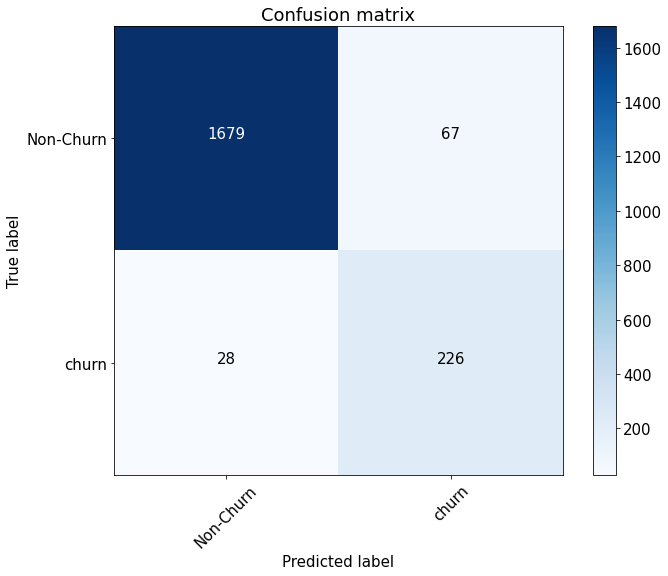

In [36]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > metrics[0]['thershhold'])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [37]:
roc_auc_score(y_test, preds)

0.9832913926996238

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 